In [1]:
# установка необходимых библиотек (при необходимости)

#!pip install patool
#!pip install category_encoders

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.metrics
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Загрузка данных

In [2]:
aggregates = pd.read_csv('aggregates.csv', parse_dates=['report_date','cre_date'])
print(aggregates.shape)
aggregates.head()

(177963, 220)


,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,...,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
0,4268,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8951,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8008,2019-11-01,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1615,2019-11-01,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Нам важно показывать ли рекламу клиенту, иначе говоря, нуждается ли он хотя бы в одном потребительском кредите. 
### Поэтому создадим атрибут Y, который будет обозначать заинтересован ли клиент в потребительских кредитах

In [3]:
aggregates['y'] = aggregates['cl_open'].apply(lambda x: int(x>0))
aggregates[['y']].head()

,y
0,0
1,0
2,0
3,0
4,0


Text(0, 0.5, 'Количество открытых кредитов')

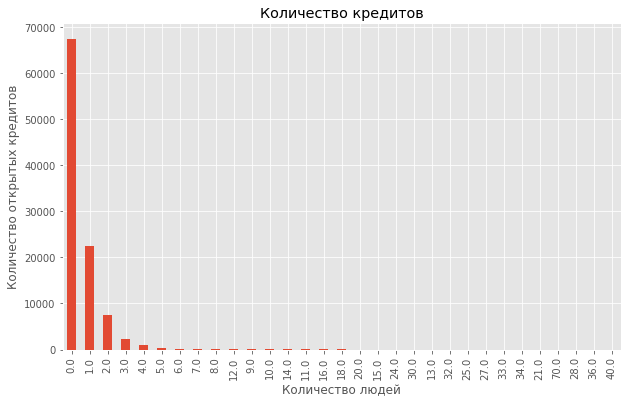

In [4]:
ax = aggregates['cl_open'].value_counts().plot(kind = 'bar', figsize = (10,6), title = 'Количество кредитов')
ax.set_xlabel("Количество людей")
ax.set_ylabel("Количество открытых кредитов")

In [5]:
aggregates.drop(['cl_open'],axis=1,inplace=True)

Заменим '',' ','0','unknown' в категориальных признаках на Na

In [7]:
obj_col = aggregates.select_dtypes('O').columns.to_list()#object
for col in obj_col:
    aggregates[col]=aggregates[col].replace('0','')
    aggregates[col].replace(' ',pd.NA, inplace = True)
    aggregates[col].replace('unknown',pd.NA, inplace = True)
    aggregates[col].replace('',pd.NA, inplace = True)

In [6]:
transactions = pd.read_csv('transactions.csv',parse_dates=['last_day_month'])
transactions.head()

,client_id,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
0,1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.0,30.000000
1,7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.0,197.800000
2,9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.0,494.939583
3,4562,2019-12-31,FINANCIAL SERVICES,15000.00,1,15000.00,15000.0,15000.000000
4,7112,2020-02-29,BUSINESS SERVICES,887.60,3,107.10,413.7,295.866666


# Предварительная обработка

## 1.  Объединим датасеты

### В transactions транзакции за месяц, а в aggregates данные на конкретный день, поэтому таблицы надо объединять по id клиента и месяцу(последнему дню месяца). 
### Добавим в aggregates последний день месяца

In [8]:
import datetime


def get_last_day_of_month(any_day):
    """Получает на вход дату, возвращает дату последнего дня в этом месяце"""
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    return next_month - datetime.timedelta(days=next_month.day)


last_day_month=[]
for i in range(len(aggregates.report_date)):
    last_day_month.append(get_last_day_of_month(aggregates.report_date[i]))
    
aggregates["last_day_month"] = last_day_month
aggregates[["report_date","last_day_month"]].head()

,report_date,last_day_month
0,2019-11-01,2019-11-30
1,2019-11-01,2019-11-30
2,2019-11-01,2019-11-30
3,2019-11-01,2019-11-30
4,2019-11-01,2019-11-30


In [9]:
print(f"(aggregates) Количество строк до удаления = {aggregates[['client_id','last_day_month']].shape[0]}")
print(f"(aggregates) Количество строк после удаления дубликатов = {aggregates[['client_id','last_day_month']].drop_duplicates().shape[0]}")

(aggregates) Количество строк до удаления = 177963
(aggregates) Количество строк после удаления дубликатов = 177963


### Нет повторений пар ['client_id','last_day_month'], а значит в любом месяце не было больше 1 записи ни о каком клиенте

In [10]:
print(f"(transactions) Количество строк до удаления = {transactions[['client_id','last_day_month']].shape[0]}")
print(f"(transactions) Количество строк после удаления дубликатов = {transactions[['client_id','last_day_month']].drop_duplicates().shape[0]}")

(transactions) Количество строк до удаления = 751747
(transactions) Количество строк после удаления дубликатов = 188556


### Есть повторения пар ['client_id','last_day_month']

In [12]:
print(f"(transactions) Количество строк до удаления = {transactions[['client_id','last_day_month','mcc_group']].shape[0]}")
print(f"(transactions) Количество строк после удаления дубликатов = {transactions[['client_id','last_day_month','mcc_group']].drop_duplicates().shape[0]}")

(transactions) Количество строк до удаления = 751747
(transactions) Количество строк после удаления дубликатов = 751747


### Нет повторений пар ['client_id','last_day_month','mcc_group']
### Значит, в любом месяце в любой группе МСС не было больше 1 записи ни о каком клиенте


### Как объединять таблицы?

### 1 вариант Добавить к информации о клиенте его транзакции за месяц. Поскольку транзакции у одного человека за один месяц может быть много, нам придется сгруппировать все транзакции клиента(например, взять среднее значение всех сумм транзакций за месяц, моду группы МСС). Однако при таком подходе теряется информация о том, сколько денег было потрачено на конкретную группу МСС.

### 2 вариант) Добавить к каждой записи о транзакциях за месяц на опеределенную группу МСС информацию об осуществившем их клиенте. При таком подходе информация о затратах на группы МСС сохраняется. Выберем этот вариант

In [13]:
df = aggregates.merge(transactions, on=['client_id','last_day_month'], how='right')
df.head()

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,...,bank_90_119_5y_debtor,bank_120plus_5y_debtor,y,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
0,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,FINANCIAL SERVICES,200000.00,1,200000.00,200000.0,200000.000
1,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,AUTO,32623.38,4,975.87,23200.0,8155.845
2,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,MEDICAL SERVICES,42400.00,1,42400.00,42400.0,42400.000
3,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,REPAIR SERVICES,8997.50,1,8997.50,8997.5,8997.500
4,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,NON FOOD RETAIL,2555.00,1,2555.00,2555.0,2555.000


## Наблюдаем очень большое количество отсутствующих значений

In [14]:
#удаляем записи, целиком состоящие из Na
df.dropna(how='all',inplace=True)  
df.head()

,client_id,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,...,bank_90_119_5y_debtor,bank_120plus_5y_debtor,y,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
0,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,FINANCIAL SERVICES,200000.00,1,200000.00,200000.0,200000.000
1,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,AUTO,32623.38,4,975.87,23200.0,8155.845
2,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,MEDICAL SERVICES,42400.00,1,42400.00,42400.0,42400.000
3,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,REPAIR SERVICES,8997.50,1,8997.50,8997.5,8997.500
4,3485,2019-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2019-11-30,NON FOOD RETAIL,2555.00,1,2555.00,2555.0,2555.000


In [15]:
# Смотрим на процент не пропущенных значений в колонках
col = df.describe(include='all').T[['count']].apply(lambda x: x/df.shape[0]).sort_values(by = 'count', ascending = False)
col.tail()

,count
max_term_50_5y_closed,0.0820768
ratio_cl_closed_gr500k,0.0810313
max_term_50_5y_open,0.0593937
min_amt_term_g1y_closed,0.0316583
max_amt_foreign_cur_5y,0.0205801


In [16]:
#атрибуты, где больше 50% не пропущенных значений
cols = col[col['count']>0.5]
cols.tail()

,count
second_payment_default,0.511439
cnt_adv_repayment,0.511439
cnt_adv_repayment_gr_500k,0.511439
mrtg_open,0.511439
cnt_opened,0.511439


In [17]:
#оставляем только такие атрибуты
df1 = df[cols.index]
df1.head()

,client_id,last_day_month,att_sum_max,att_sum_min,att_cnt,att_sum,mcc_group,att_sum_avg,age,report_date,...,bank_count_first_12m_1,bank_count_first_12m_30,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,cnt_adv_repayment,cnt_adv_repayment_gr_500k,mrtg_open,cnt_opened
0,3485,2019-11-30,200000.0,200000.00,1,200000.00,FINANCIAL SERVICES,200000.000,43.954301,2019-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3485,2019-11-30,23200.0,975.87,4,32623.38,AUTO,8155.845,43.954301,2019-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3485,2019-11-30,42400.0,42400.00,1,42400.00,MEDICAL SERVICES,42400.000,43.954301,2019-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3485,2019-11-30,8997.5,8997.50,1,8997.50,REPAIR SERVICES,8997.500,43.954301,2019-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3485,2019-11-30,2555.0,2555.00,1,2555.00,NON FOOD RETAIL,2555.000,43.954301,2019-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#Удаляем все строчки, где есть хотя бы одно значение Na
df2 = df1.dropna(how = 'any', inplace = False)

In [19]:
#Проверяем остались ли пропущенные значения
df2.isna().sum().value_counts()

0    114
dtype: int64

In [20]:
print(df2.shape)
df2.head()

(313259, 114)


,client_id,last_day_month,att_sum_max,att_sum_min,att_cnt,att_sum,mcc_group,att_sum_avg,age,report_date,...,bank_count_first_12m_1,bank_count_first_12m_30,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,cnt_adv_repayment,cnt_adv_repayment_gr_500k,mrtg_open,cnt_opened
6,8008,2019-11-30,132.0,132.0,2,264.00,AUTO,132.000000,39.892473,2019-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,8008,2019-11-30,514.0,17.0,18,3006.00,NON FOOD RETAIL,167.000000,39.892473,2019-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
8,8008,2019-11-30,649.0,649.0,1,649.00,PUBLIC SERVICE,649.000000,39.892473,2019-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
9,8008,2019-11-30,10000.0,7000.0,2,17000.00,FINANCIAL SERVICES,8500.000000,39.892473,2019-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
10,8008,2019-11-30,3631.0,40.0,34,10657.15,RETAIL STORES,313.445588,39.892473,2019-11-01,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [21]:
# смотрим на типы атрибутов
set(df2.dtypes.to_list())

{dtype('int64'), dtype('float64'), dtype('<M8[ns]'), dtype('O')}

In [22]:
obj_col = df2.select_dtypes('O').columns.to_list()                   # object
date_col= df2.select_dtypes('<M8[ns]').columns.to_list()             # даты
num_col = df2.select_dtypes(['int64', 'float64']).columns.to_list()  # числовые

In [23]:
df2[date_col].head()

,last_day_month,report_date
6,2019-11-30,2019-11-01
7,2019-11-30,2019-11-01
8,2019-11-30,2019-11-01
9,2019-11-30,2019-11-01
10,2019-11-30,2019-11-01


## id клиента и отчетная дата никак не влияют на то, заинтересован ли клиент в потребительских кредитах, поэтому удалим эти атрибуты

In [24]:
date_and_id=date_col
date_and_id.append("client_id")
date_and_id

['last_day_month', 'report_date', 'client_id']

In [25]:
df2.drop(date_and_id,axis=1,inplace=True)
df2.head()

,att_sum_max,att_sum_min,att_cnt,att_sum,mcc_group,att_sum_avg,age,y,extra_card_ind,num_prem_cards,...,bank_count_first_12m_1,bank_count_first_12m_30,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,cnt_adv_repayment,cnt_adv_repayment_gr_500k,mrtg_open,cnt_opened
6,132.0,132.0,2,264.00,AUTO,132.000000,39.892473,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
7,514.0,17.0,18,3006.00,NON FOOD RETAIL,167.000000,39.892473,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
8,649.0,649.0,1,649.00,PUBLIC SERVICE,649.000000,39.892473,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
9,10000.0,7000.0,2,17000.00,FINANCIAL SERVICES,8500.000000,39.892473,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
10,3631.0,40.0,34,10657.15,RETAIL STORES,313.445588,39.892473,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


## Нормализуем числовые атрибуты
## Используем Normalizer, потому что в дальнейшем используем One Hot Encoding

In [26]:
y=df2["y"]
X=df2.drop(['y'],axis=1)
num_col = X.select_dtypes(['int64', 'float64']).columns.to_list()

normalizer=Normalizer()
X[num_col]=normalizer.fit_transform(X[num_col])

X.head()

,att_sum_max,att_sum_min,att_cnt,att_sum,mcc_group,att_sum_avg,age,extra_card_ind,num_prem_cards,num_debit_cards,...,bank_count_first_12m_1,bank_count_first_12m_30,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,cnt_adv_repayment,cnt_adv_repayment_gr_500k,mrtg_open,cnt_opened
6,0.000633,0.000633,0.000010,0.001267,AUTO,0.000633,0.000191,0.000005,0.000005,0.00001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.0
7,0.002467,0.000082,0.000086,0.014425,NON FOOD RETAIL,0.000801,0.000191,0.000005,0.000005,0.00001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.0
8,0.003115,0.003115,0.000005,0.003115,PUBLIC SERVICE,0.003115,0.000191,0.000005,0.000005,0.00001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.0
9,0.047712,0.033399,0.000010,0.081111,FINANCIAL SERVICES,0.040555,0.000190,0.000005,0.000005,0.00001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.0
10,0.017400,0.000192,0.000163,0.051071,RETAIL STORES,0.001502,0.000191,0.000005,0.000005,0.00001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00001,0.0,0.0,0.0


## Обработаем категориальные признаки c помощью GetDummies()



In [27]:
X=pd.get_dummies(X)
X.head()

,att_sum_max,att_sum_min,att_cnt,att_sum,att_sum_avg,age,extra_card_ind,num_prem_cards,num_debit_cards,num_credit_cards,...,app_employment_type_nm_Юриспруденция,app_employment_type_nm_административно-хозяйственная служба,"app_employment_type_nm_бухгалтерия, финансы, планирование","app_employment_type_nm_кадровая служба, секретариат",app_employment_type_nm_основная деятельность организации/предпр,app_employment_type_nm_основная деятельность организации/предприятия,app_employment_type_nm_служба безопасности,app_employment_type_nm_телекоммуникации,app_employment_type_nm_технический персонал,app_employment_type_nm_юридическая служба
6,0.000633,0.000633,0.000010,0.001267,0.000633,0.000191,0.000005,0.000005,0.00001,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0.002467,0.000082,0.000086,0.014425,0.000801,0.000191,0.000005,0.000005,0.00001,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0.003115,0.003115,0.000005,0.003115,0.003115,0.000191,0.000005,0.000005,0.00001,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0.047712,0.033399,0.000010,0.081111,0.040555,0.000190,0.000005,0.000005,0.00001,0.0,...,0,0,0,0,0,0,0,0,0,0
10,0.017400,0.000192,0.000163,0.051071,0.001502,0.000191,0.000005,0.000005,0.00001,0.0,...,0,0,0,0,0,0,0,0,0,0


## Корреляционный анализ

In [28]:
#атрибуты с корреляцией к целевому признаку более пороговой
z = 0.15

df3 = X.join(y)
y_cor = df3.corr()['y']
cor = y_cor[abs(y_cor) > z]
sorted_cor = cor.sort_values(ascending = False)
print("Кол-во таких атрибутов:",len(cor))
for i in range(10):
    print(sorted_cor.index[i],': ',sorted_cor[i])
print("Еще ",len(cor)-10)

Кол-во таких атрибутов: 18
y :  1.0
outstanding_open :  0.56113742370939
outstanding :  0.5511097925332403
total_liab_sum_bank_open_agr :  0.5485980833405151
max_liab_sum_bank_open :  0.5194326229782631
avg_liab_sum_total_open_agr :  0.47522461043745884
total_liab_sum_bki_open_agr :  0.2490378232522848
max_liab_sum_bki_open :  0.2300059397921952
bank_ki_flg :  -0.15337945451580332
first_opened :  -0.1534144981473842
Еще  8


In [29]:
#Оставим только атрибуты с корреляцией больше 0.15
df4=df3[cor.index]
df4.head()

,att_sum_max,att_sum_min,att_cnt,att_sum,att_sum_avg,age,first_opened,max_liab_sum_bank_open,avg_liab_sum_total_open_agr,total_liab_sum_bank_open_agr,avg_liab_sum_total_closed_agr,total_liab_sum_bki_open_agr,max_liab_sum_bki_open,outstanding_open,outstanding,cnt_liability_types,bank_ki_flg,y
6,0.000633,0.000633,0.000010,0.001267,0.000633,0.000191,0.000070,0.0,0.0,0.0,0.241321,0.0,0.0,0.0,0.0,0.000005,0.0,0.0
7,0.002467,0.000082,0.000086,0.014425,0.000801,0.000191,0.000070,0.0,0.0,0.0,0.241296,0.0,0.0,0.0,0.0,0.000005,0.0,0.0
8,0.003115,0.003115,0.000005,0.003115,0.003115,0.000191,0.000070,0.0,0.0,0.0,0.241317,0.0,0.0,0.0,0.0,0.000005,0.0,0.0
9,0.047712,0.033399,0.000010,0.081111,0.040555,0.000190,0.000069,0.0,0.0,0.0,0.239916,0.0,0.0,0.0,0.0,0.000005,0.0,0.0
10,0.017400,0.000192,0.000163,0.051071,0.001502,0.000191,0.000070,0.0,0.0,0.0,0.240970,0.0,0.0,0.0,0.0,0.000005,0.0,0.0


### Избавимся от коллинеарных признаков

In [30]:
from feature_selector import FeatureSelector


X=df4.drop(['y'],axis=1)
fs = FeatureSelector(data = X, labels = X.columns)
fs.identify_collinear(correlation_threshold = 0.7)

10 features with a correlation magnitude greater than 0.70.



### Тепловая карта для признаков, у которых есть корреляция больше пороговой

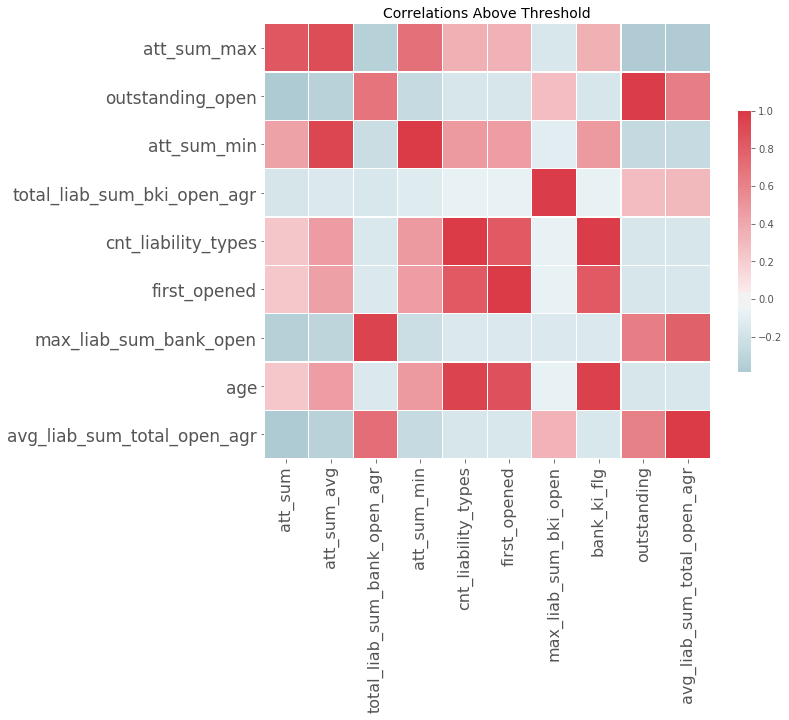

In [31]:
fs.plot_collinear()

### Один из пары коллинеарных признаков нужно удалить. В первой колонке удаляемый признак, во второй - признак, с которым сильно коррелируют признаки из первой колонки, в третьей - коэф корреляции

In [33]:
collinear_features = fs.ops['collinear']
print(collinear_features)
fs.record_collinear

['att_sum_min', 'att_sum', 'att_sum_avg', 'first_opened', 'avg_liab_sum_total_open_agr', 'total_liab_sum_bank_open_agr', 'max_liab_sum_bki_open', 'outstanding', 'cnt_liability_types', 'bank_ki_flg']


,drop_feature,corr_feature,corr_value
0,att_sum_min,att_sum_max,0.701046
1,att_sum,att_sum_max,0.835997
2,att_sum_avg,att_sum_max,0.892759
3,att_sum_avg,att_sum_min,0.930367
4,first_opened,age,0.867460
5,avg_liab_sum_total_open_agr,max_liab_sum_bank_open,0.783888
6,total_liab_sum_bank_open_agr,max_liab_sum_bank_open,0.947145
7,total_liab_sum_bank_open_agr,avg_liab_sum_total_open_agr,0.712689
8,max_liab_sum_bki_open,total_liab_sum_bki_open_agr,0.973090
9,outstanding,outstanding_open,0.982184


In [34]:
final_cols=df4.columns.drop(collinear_features)
print(len(final_cols))
final_cols

8


Index(['att_sum_max', 'att_cnt', 'age', 'max_liab_sum_bank_open',
       'avg_liab_sum_total_closed_agr', 'total_liab_sum_bki_open_agr',
       'outstanding_open', 'y'],
      dtype='object')

In [35]:
#уберем по одному из пары коллинеарных признаков
df5=df4[final_cols]
df5.head()

,att_sum_max,att_cnt,age,max_liab_sum_bank_open,avg_liab_sum_total_closed_agr,total_liab_sum_bki_open_agr,outstanding_open,y
6,0.000633,0.000010,0.000191,0.0,0.241321,0.0,0.0,0.0
7,0.002467,0.000086,0.000191,0.0,0.241296,0.0,0.0,0.0
8,0.003115,0.000005,0.000191,0.0,0.241317,0.0,0.0,0.0
9,0.047712,0.000010,0.000190,0.0,0.239916,0.0,0.0,0.0
10,0.017400,0.000163,0.000191,0.0,0.240970,0.0,0.0,0.0


# Описательная статистика

In [36]:
df5.describe()

,att_sum_max,att_cnt,age,max_liab_sum_bank_open,avg_liab_sum_total_closed_agr,total_liab_sum_bki_open_agr,outstanding_open,y
count,3.132590e+05,3.132590e+05,3.132590e+05,313259.000000,313259.000000,313259.000000,313259.000000,313259.000000
mean,6.716928e-02,2.871138e-04,4.963283e-03,0.152994,0.116854,0.055757,0.171462,0.415484
std,1.485128e-01,1.308611e-03,2.699362e-02,0.192930,0.134249,0.139210,0.185235,0.492806
min,1.766834e-09,4.260636e-09,1.429488e-07,0.000000,0.000000,0.000000,-0.016333,0.000000
25%,4.124999e-04,9.952127e-07,1.221112e-05,0.000000,0.007003,0.000000,0.000000,0.000000
50%,1.947479e-03,3.884668e-06,3.655938e-05,0.000000,0.067248,0.000000,0.100231,0.000000
75%,1.936270e-02,2.567196e-05,1.712378e-04,0.348439,0.173918,0.000000,0.341716,1.000000
max,7.019364e-01,1.087379e-01,7.278848e-01,0.651927,0.558805,0.935702,0.706004,1.000000


0.0    183105
1.0    130154
Name: y, dtype: int64


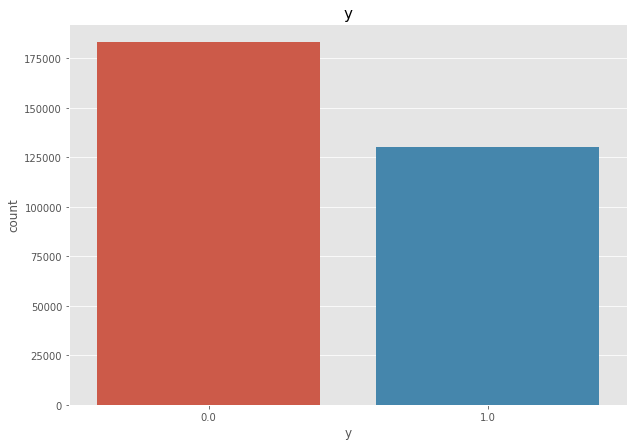

In [37]:
plt.figure(figsize=(10,7))
plt.title('y', fontsize = 15)
sns.countplot(x='y',data=df5)
print(df5.y.value_counts())

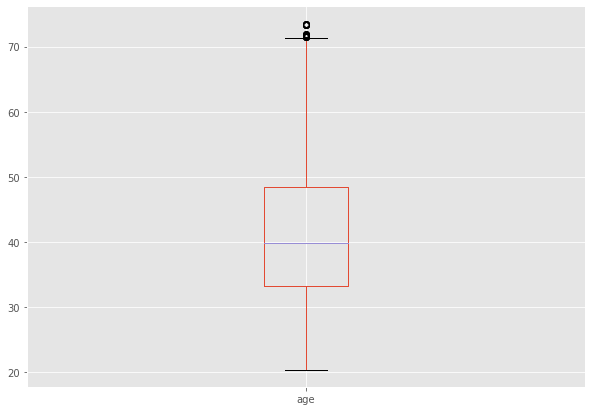

In [38]:
plt.figure(figsize=(10,7))
df2[["age"]].boxplot()

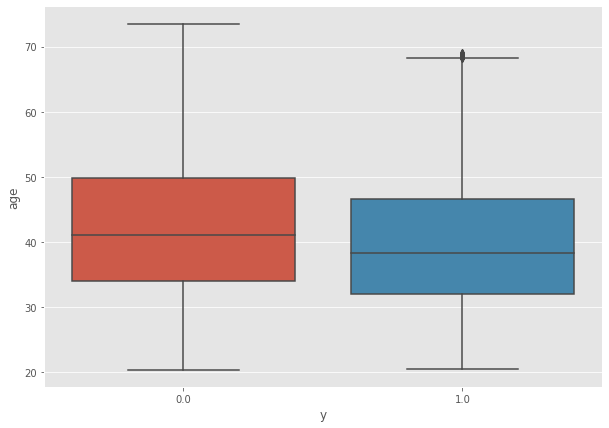

In [39]:
plt.figure(figsize=(10,7))
sns.boxplot(x='y', y='age', data=df2)

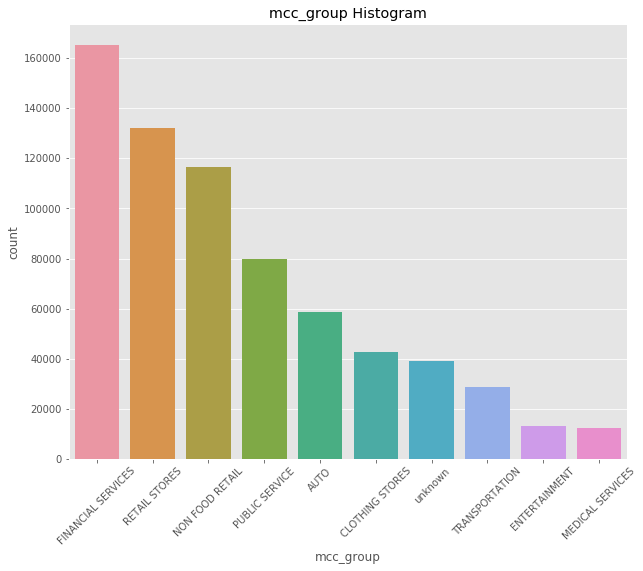

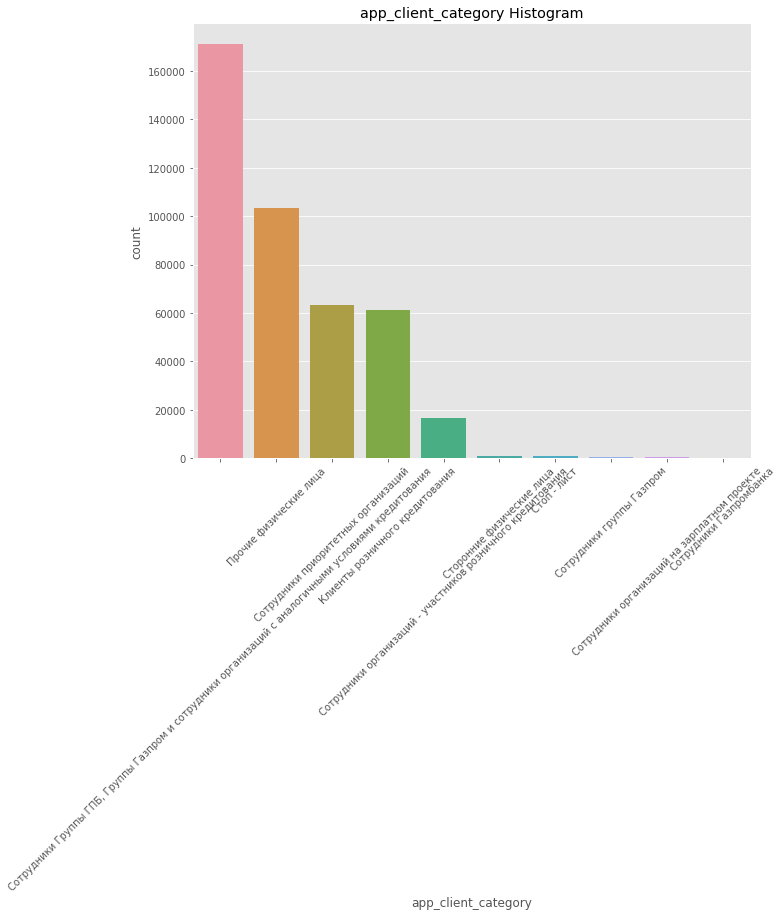

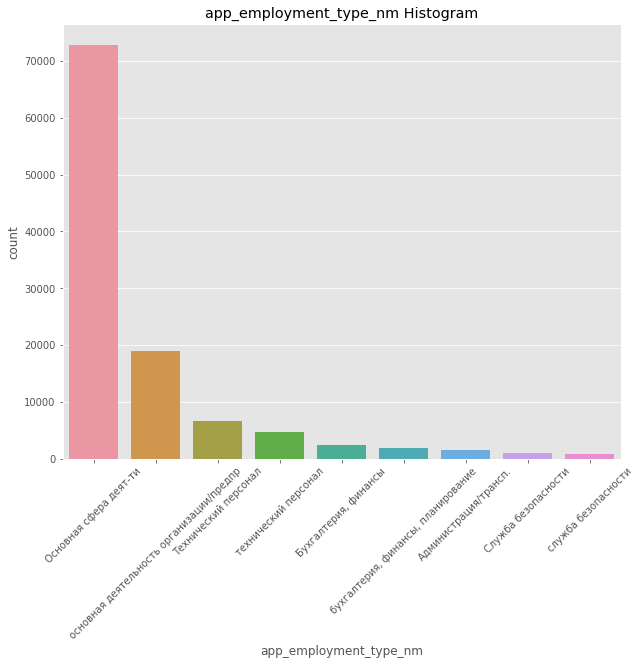

In [40]:
def get_cols(df) -> list:
    '''
    function return list of name numbers and categorials columns
    '''
    categorical_feature_mask = df.dtypes == object
    number_feature_mask = df.dtypes != object
    numbers_cols = df.columns[number_feature_mask].tolist()
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    return [numbers_cols, categorical_cols]

numbers_cols, categorical_cols = get_cols(df2)

for column in categorical_cols:

    columne_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index

    if '' in columne_most_freq:
        columne_most_freq = columne_most_freq.drop('')

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))


    plt.title(f'{column} Histogram')
    sns.countplot(
            df[df[column].isin(columne_most_freq)][column],
            order=columne_most_freq
    )

    plt.xticks(rotation=45)



    plt.show()

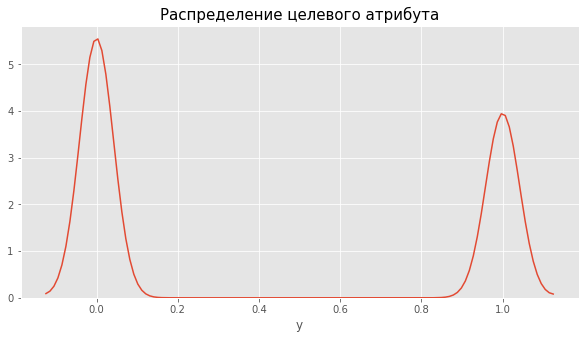

In [41]:
plt.figure(figsize = (10, 5))
sns.distplot(a=df5["y"], hist=False, kde=True, rug=False)
plt.title('Распределение целевого атрибута', fontsize = 15)
plt.grid(True)

In [42]:
X=df5.drop('y', axis=1)
y=df5["y"]
X.head()

,att_sum_max,att_cnt,age,max_liab_sum_bank_open,avg_liab_sum_total_closed_agr,total_liab_sum_bki_open_agr,outstanding_open
6,0.000633,0.000010,0.000191,0.0,0.241321,0.0,0.0
7,0.002467,0.000086,0.000191,0.0,0.241296,0.0,0.0
8,0.003115,0.000005,0.000191,0.0,0.241317,0.0,0.0
9,0.047712,0.000010,0.000190,0.0,0.239916,0.0,0.0
10,0.017400,0.000163,0.000191,0.0,0.240970,0.0,0.0


In [43]:
# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

## Выбор метрики

accuracy — доля правильных ответов алгоритма.
Эта метрика бесполезна в задачах с неравными классами.
Большинство клиентов не заинтересовано в кредитах, поэтому, если алгоритм не покажет рекламу никому, эта метрика все равно покажет неплохой результат.

precision=true positive/(true positive+false positive) 
Доля полезной рекламы среди всей, которую мы дали.
Precison тем лучше, чем меньше рекламы данной зря среди всей рекламы.
Эта метрика полезна, если для нас важнее всего не показывать рекламу впустую.

recall= true positive/(true positive+false negative)  
Cколько людей, которым мы правильно дали рекламу,среди тех, кому должны были её дать.
recall тем лучше, чем меньше людей, которым не дали рекламу, но должны были.
Эта метрика полезна, если для нас важнее, чтобы каждый, кто заинтересован в потребительском кредите, увидел его рекламу.

Для нас важнее охватить всех, кто заинтересован в потребительском кредите, поэтому выбираем метрику recall

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score


dtree = DecisionTreeClassifier().fit(X_train, y_train)
d_predict = dtree.predict(X_test)
recall_train = sklearn.metrics.recall_score(y_train, dtree.predict(X_train))
recall_test = sklearn.metrics.recall_score(y_test, d_predict)
print(f'Recall DecisionTreeClassifier (train) = {recall_train:.2%}')
print(f'Recall DecisionTreeClassifier (test) = {recall_test:.2%}')                                        

Recall DecisionTreeClassifier (train) = 100.00%
Recall DecisionTreeClassifier (test) = 99.44%


In [45]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
recall_test=sklearn.metrics.recall_score(y_test, rf_predict)
recall_train=sklearn.metrics.recall_score(y_train, rf.predict(X_train))
print(f'Recall RandomForestClassifier (train) = {recall_train:.2%}')
print(f'Recall RandomForestClassifier (test) = {recall_test:.2%}')  

Recall RandomForestClassifier (train) = 100.00%
Recall RandomForestClassifier (test) = 99.66%


## Подбор параметров

In [46]:
import matplotlib.pyplot as plt


def show_parameter_selection(train_acc, test_acc, grid, xlabel, ymin=0.99, ymax=1.005):
    plt.style.use('ggplot')
    %matplotlib inline
    train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(grid, train_acc, alpha=0.5, color='blue', label='train')
    ax.plot(grid, test_acc, alpha=0.5, color='red', label='test')
    ax.set_title("Подбор " + xlabel)
    ax.legend(loc='best')
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel("recall")
    ax.set_xlabel(xlabel)

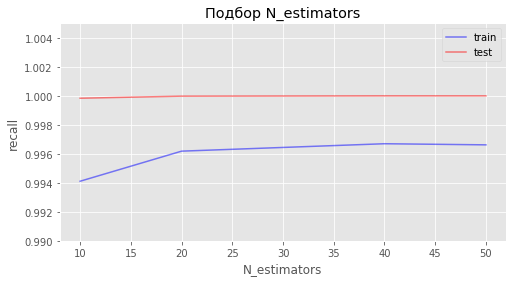

In [47]:
train_acc = []
test_acc = []
trees_grid = [10,20,40,50]
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(sklearn.metrics.recall_score(y_test, rfc.predict(X_test)))
    test_acc.append(sklearn.metrics.recall_score(y_train, rfc.predict(X_train)))

show_parameter_selection(train_acc, test_acc, trees_grid, "N_estimators")   

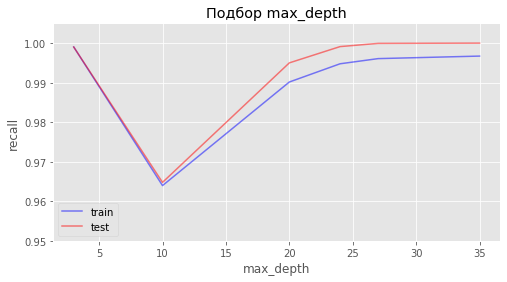

In [51]:
train_acc = []
test_acc = []
max_depth_grid = [3, 10, 20, 24,27,35]
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42,max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(sklearn.metrics.recall_score(y_test, rfc.predict(X_test)))
    test_acc.append(sklearn.metrics.recall_score(y_train, rfc.predict(X_train)))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0.95)   

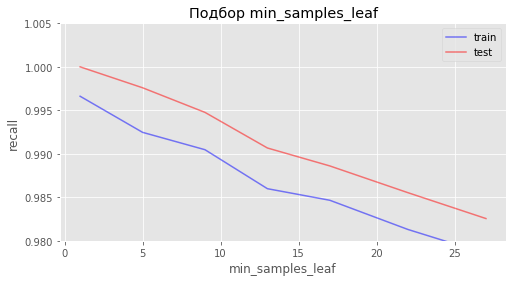

In [49]:
train_acc = []
test_acc = []
min_samples_leaf_grid = [1, 5, 9, 13, 17, 22, 27]
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42,min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(sklearn.metrics.recall_score(y_test, rfc.predict(X_test)))
    test_acc.append(sklearn.metrics.recall_score(y_train, rfc.predict(X_train)))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0.98)   

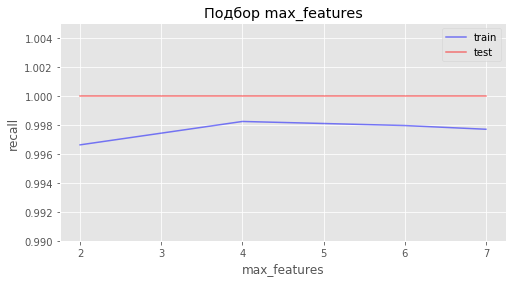

In [52]:
train_acc = []
test_acc = []
max_features_grid = [2, 4, 6, 7]
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(sklearn.metrics.recall_score(y_test, rfc.predict(X_test)))
    test_acc.append(sklearn.metrics.recall_score(y_train, rfc.predict(X_train)))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features")   

Готовая модель

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=50, max_depth=30, min_samples_leaf=1, max_features=4)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)
recall_test=sklearn.metrics.recall_score(y_test, rf_predict)
recall_train=sklearn.metrics.recall_score(y_train, rf.predict(X_train))
print(f'Recall RandomForestClassifier (train) = {recall_train:.2%}')
print(f'Recall RandomForestClassifier (test) = {recall_test:.2%}')  

Recall RandomForestClassifier (train) = 100.00%
Recall RandomForestClassifier (test) = 99.80%


Feature ranking:
1. outstanding_open 0.356138 
2. max_liab_sum_bank_open 0.268467 
3. age 0.153674 
4. total_liab_sum_bki_open_agr 0.136385 
5. avg_liab_sum_total_closed_agr 0.069084 
6. att_sum_max 0.011193 
7. att_cnt 0.005059 


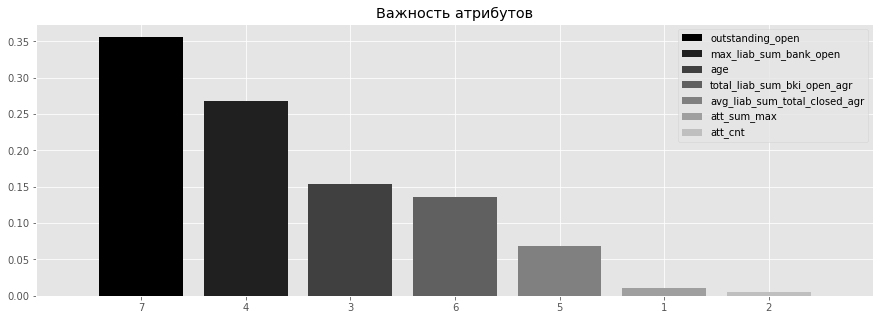

In [56]:
importances=rf.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = len(indices)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            X_train.columns[indices[f]], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность атрибутов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(X_train.columns[i]) 
                  for i in indices]);

In [55]:
d2=pd.DataFrame(rf.predict(X_train.head(12)),columns=['predicted'])
d1=pd.DataFrame(list(y_train.head(12)),index=d2.index,columns=['original'])
d1.join(d2)

,original,predicted
0,0.0,0.0
1,1.0,1.0
2,0.0,0.0
3,1.0,1.0
4,0.0,0.0
5,1.0,1.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Вывод:

Целью нашей работы было создание системы персонализированных рекомендаций, которая определяла бы склонность клиента к продукту "потребительский кредит"

В ходе анализа было установлено, что на целевую переменную (заинтересованность в кредите) больше всего влияют следующие параметры:

outstanding_open (значим на 36%) - суммарная оставшаяся непогашенная задолженность по открытым счетам,
max_liab_sum_bank_open (значим на 27%) - максимальная переоцененная в рубли сумма обязательства по открытым договорам по данным банка
age(значим на 16%) - возраст клиента (в годах) на дату расчета
total_liab_sum_bki_open_agr(значим на 14%) - общая переоцененная в рубли сумма обязательства по открытым договорам по данным бки

Метрикой точности модели был выбран recall, так как для нас важнее, чтобы каждый, кто заинтересован в потребительском кредите, увидел его рекламу.
Главная функция модели выполняется, метрика принимает значение 99.80%